In [4]:
# import pandas as pd
# from pandas_profiling import ProfileReport
# from pandasql import sqldf
# pysqldf = lambda q: sqldf(q, globals())
# pd.set_option('display.max_rows', None)
# import seaborn as sns
# import matplotlib.pyplot as plt

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from textblob import TextBlob, Word, Blobber

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, confusion_matrix
# from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas_profiling import ProfileReport
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
from sklearn.feature_extraction.text import CountVectorizer
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [5]:
df = pd.read_csv("../input/fake-news-dataset/train.csv")

In [6]:
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# profile.to_notebook_iframe()
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [7]:
# List all columms
df.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

### Check null value's count

In [8]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

### Delete null values

In [9]:
# deleted the records which has null value. totoal 2.5% records
df.dropna(inplace=True)
df.label.count()

18285

#### <font color=green> ANALYSIS:- for now dropped rows which has null and thsoe are almost 2.5% . We can use title when text is null or vice versa  </font>
 

In [10]:
del df['id']

#### <font color=green> ANALYSIS:- This column is 100% unique and since we don’t want to overfit the model, hence we are removing id column.  </font>
 

### Create new feature for number of words in the string and length of the string

In [11]:
df['text_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))


In [12]:
df['title_len'] = df['title'].astype(str).apply(len)
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))


In [13]:
df['title_word_count'].head()

0    14
1     9
2     7
3    10
4    14
Name: title_word_count, dtype: int64

### Create the two dataframes for the analysis

In [14]:
fakenews = df[df["label"] == 1]
realnews = df[df["label"] == 0]

## Univariate Analysis

### The distribution of text length

In [15]:
# Distrubution of text length 
df['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='Number Of Records',
    title='Text Length Distribution of "text" feature')

#### <font color=green> ANALYSIS:- This column has more than 72% data which length of text is greater than 2k  </font>
 

### The distribution of word count

In [16]:
# Distrubution of word count 
df['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='Number Of Records',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution of "text" feature')

### The distribution of Title word count

In [17]:
# Distrubution of word count 
df['title_word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='Number Of Records',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution of "text" feature')

#### <font color=green> ANALYSIS:- This column has more than 65% records which word count is less than 900 words  </font>
 

#### Dataset is balanced or not

In [18]:
df.groupby('label').count()['word_count'].iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Bar chart of label and word count', xTitle='label')

#### <font color=green> ANALYSIS:- 56% has 0s and 44% has 1s that has almost balanced word count   </font>

## Calculate Unigram, Bigram & Trigram of fake and real news and analyze

In [19]:
# Function to calcualte unigram, bigram and trigram
def get_top_n_gram_words(corpus, n=None,gram=1):
    vec = CountVectorizer(ngram_range=(gram, gram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#### The distribution of top unigrams before removing stop words of fake news

In [20]:
# fakenews unigram : 
common_words = get_top_n_gram_words(fakenews['text'], 20)
# for word, freq in common_words:
#     print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df1.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top bigrams before removing stop words of fake news

In [21]:
# fakenews bigram
common_words = get_top_n_gram_words(fakenews['text'], 20,2)
# for word, freq in common_words:
#     print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['commonTextbigram' , 'count'])
df2.groupby('commonTextbigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in text before removing stop words')

#### The distribution of top trigrams before removing stop words of fake news

In [22]:
# fakenews Trigram
common_words = get_top_n_gram_words(fakenews['text'], 20,3)
# for word, freq in common_words:
#     print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['commonTextTrigram' , 'count'])
df3.groupby('commonTextTrigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in text before removing stop words')

#### The distribution of top unigrams before removing stop words of real news

In [23]:
# realnews unigram
common_words = get_top_n_gram_words(realnews['text'], 20)
# for word, freq in common_words:
#     print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df4.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top bigrams before removing stop words of real news

In [24]:
# realnews trigram
common_words = get_top_n_gram_words(realnews['text'], 20,2)
# for word, freq in common_words:
#     print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df6.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top trigrams before removing stop words of real news

In [25]:
# realnews trigram
common_words = get_top_n_gram_words(realnews['text'], 20,3)
# for word, freq in common_words:
#     print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df6.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### As is the case when working with any kind of text, the first step is separating each article’s body text into tokens to get a corpus. Using the corpus, I can get features from the words. To tokenize each article, I used the NLTK package to do the following: <br> 1) Imported English words <br>2) Separated each article into tokens (removes whitespaces) <br>3) All words lowercased <br> 4) Removed punctuation and stop words <br> 5)   Lemmatized (converted to root form) words 

In [26]:
# After removing stopwords 
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()  

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def processText(df):
    by_article_list=[]
    for article in (df["text"]):
        words = word_tokenize(article)
        words = [word.lower() for word in words if word.isalpha()] #lowercase
        words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
        words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form
        by_article_list.append(' '.join(words))
    return by_article_list

def processTitle(df):
    by_article_list=[]
    for article in (df["title"]):
        words = word_tokenize(article)
        words = [word.lower() for word in words if word.isalpha()] #lowercase
        words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
        words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form
        by_article_list.append(' '.join(words))
    return by_article_list

#### Process fakenews and realnews dataset and extract clean text 

In [28]:

fakenews['clean_text'] =processText(fakenews)

In [ ]:
realnews['clean_text'] =processText(realnews)

#### Process text from main dataframe and create the new feature for it

In [30]:
df['clean_text'] =processText(df)

In [31]:
df['clean_title'] =processTitle(df)

In [32]:
df['clean_text_len'] = df['clean_text'].astype(str).apply(len)
df['clean_text_word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
df['clean_text_title_len'] = df['clean_title'].astype(str).apply(len)
df['clean_text_title_word_count'] = df['clean_title'].apply(lambda x: len(str(x).split()))

#### data distrubtion of clean text and title word 

In [33]:
# Distrubution of word count 
df['clean_text_title_word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='Number Of Records',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution of "text" feature')

In [34]:
# Distrubution of word count 
df['clean_text_word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='Number Of Records',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution of "text" feature')

#### <font color=green> ANALYSIS:- 65%+ records has less than 5k words in text and title is fairly distributed  </font>

#### The distribution of top unigrams after cleanign the text [removing stop words,punctuation] of fake news

In [35]:
# fakenews unigram
common_words = get_top_n_gram_words(fakenews['clean_text'], 20)
# for word, freq in common_words:
#     print(word, freq)
df7 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df7.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top bigrams after cleanign the text [removing stop words,punctuation] of fake news

In [36]:
# fakenews biigram
common_words = get_top_n_gram_words(fakenews['clean_text'], 20,2)
# for word, freq in common_words:
#     print(word, freq)
df7 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df7.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top trigrams after cleanign the text [removing stop words,punctuation] of fake news

In [37]:
# fakenews triigram
common_words = get_top_n_gram_words(fakenews['clean_text'], 20,3)
# for word, freq in common_words:
#     print(word, freq)
df7 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df7.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top unigrams after cleanign the text [removing stop words,punctuation] of real news


In [38]:
# realnews unigram
common_words = get_top_n_gram_words(realnews['clean_text'], 20)
# for word, freq in common_words:
#     print(word, freq)
df7 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df7.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top bigrams after cleanign the text [removing stop words,punctuation] of real news

In [39]:
# realnews bigram
common_words = get_top_n_gram_words(realnews['clean_text'], 20,2)
# for word, freq in common_words:
#     print(word, freq)
df8 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df8.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### The distribution of top trigrams after cleanign the text [removing stop words,punctuation] of real news

In [40]:
# realnews trigram
common_words = get_top_n_gram_words(realnews['clean_text'], 20,3)
# for word, freq in common_words:
#     print(word, freq)
df9 = pd.DataFrame(common_words, columns = ['commonTextUnigram' , 'count'])
df9.groupby('commonTextUnigram').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text before removing stop words')

#### <font color=green> ANALYSIS:- After analyzing these n-grams, I ended up not using them in the modeling process because <br>1) processing time was multiplied through the use of n-grams on top of single tokens  <br>2) n-grams were pretty similar between the two classes of text and  <br>3) metrics from the results of modeling (see below) were already strong without adding n-grams. </font>
 

#### Part-Of-Speech Tagging (POS) is a process of assigning parts of speech to each word, such as noun, verb, adjective, etc. <br>We use a simple TextBlob API to dive into POS of our “Text” feature in our data set, and visualize these tags.

#### The distribution of top part-of-speech tags of text corpus of fake news

In [41]:
# The distribution of top part-of-speech tags of text corpus
blob = TextBlob(str(fakenews['text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for text corpus')

#### The distribution of top part-of-speech tags of text corpus of real news

In [42]:
# The distribution of top part-of-speech tags of text corpus
blob = TextBlob(str(realnews['text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for text corpus')

#### <font color=green> ANALYSIS:- fakenews and realnews dataframe has almost same count of POS except nouns are more in real news </font>

## Bivariate Analysis

#### Box plot is used to compare the text length of each text and label .

In [43]:
from plotly.offline import iplot
y0 = df.loc[df['label'] == 1]['text_len']
y1 = df.loc[df['label'] == 0]['text_len']



trace0 = go.Box(
    y=y0,
    name = 'fake',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'real',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "Text length Boxplot of label Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "text Length Boxplot of label Name")

#### Box plot is used to compare the word count of each text and label .

In [44]:
from plotly.offline import iplot
y0 = df.loc[df['label'] == 1]['word_count']
y1 = df.loc[df['label'] == 0]['word_count']


trace0 = go.Box(
    y=y0,
    name = 'fake',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'real',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "word count Boxplot of label Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "word count Boxplot of label Name")

#### <font color=green> ANALYSIS:- Text Word Count:- for realnews  min:1 , q1:400, Median:713, q3: 1179  <br> for fakenews  min:0 , q1:200, Median:433, q3: 875  <br> 1) Real news has the aveagage word count  is 713 and fakenews is 433 so by looking at the word count size also we can determine whether news is fake or real <br>2) there are more outlier in the fake news <br> for most of the news, fake news text length is little bit lower than the real news </font>

#### Box plot is used to compare the word count of cleaned each text and label .

In [45]:
from plotly.offline import iplot
y0 = df.loc[df['label'] == 1]['clean_text_word_count']
y1 = df.loc[df['label'] == 0]['clean_text_word_count']


trace0 = go.Box(
    y=y0,
    name = 'fake',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'real',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "word count Boxplot of label Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "word count Boxplot of label Name")

#### Box plot is used to compare the text length of each title and label .

In [46]:
from plotly.offline import iplot
y0 = df.loc[df['label'] == 1]['title_len']
y1 = df.loc[df['label'] == 0]['title_len']


trace0 = go.Box(
    y=y0,
    name = 'fake',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'real',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "Title length Boxplot of label Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Title Length Boxplot of label Name")

#### Box plot is used to compare the word count of each title and label .

In [47]:
from plotly.offline import iplot
y0 = df.loc[df['label'] == 1]['title_word_count']
y1 = df.loc[df['label'] == 0]['title_word_count']


trace0 = go.Box(
    y=y0,
    name = 'fake',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'real',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title = "Title word Count Boxplot of label Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Title Word Count Boxplot of label Name")

#### <font color=green> ANALYSIS:- Titile Text Length: for realnews  min:22 , q1:70, Median:81, q3: 89  <br> for fakenews  min:3 , q1:50, Median:67, q3: 83  <br> 1) Real news always has more than 22 words however in fake news may have less  <br>2) there are more outlier in the fake news<br>Titile Word Count: for realnews  min:4 , q1:12, Median:84, q3: 16  <br>3) for fakenews  min:1 , q1:8, Median:10.5, q3: 13 :fake news has less word compare to real news</font>

#### function for extract the words for wordcloud .

In [48]:
def extractWords(df):
    text_words = '' 
    for val in df.clean_text: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        text_words += " ".join(tokens)+" "
    return text_words

#### wordcloud for fake news

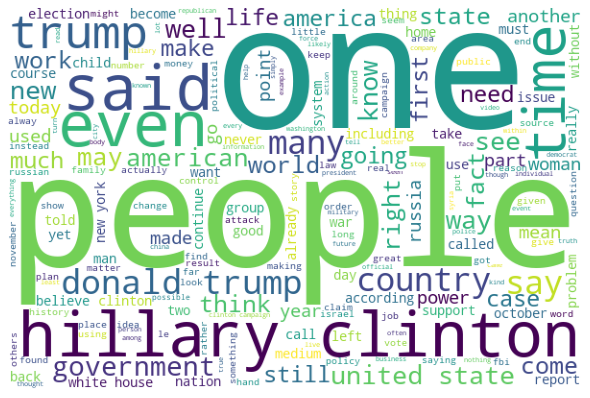

In [49]:
# worldcloud
text_words = extractWords(fakenews)
plt.subplots(figsize = (8,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 600,
                    height = 400
                        ).generate(text_words)
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.tight_layout(pad=0)
plt.show()

#### wordcloud for real news

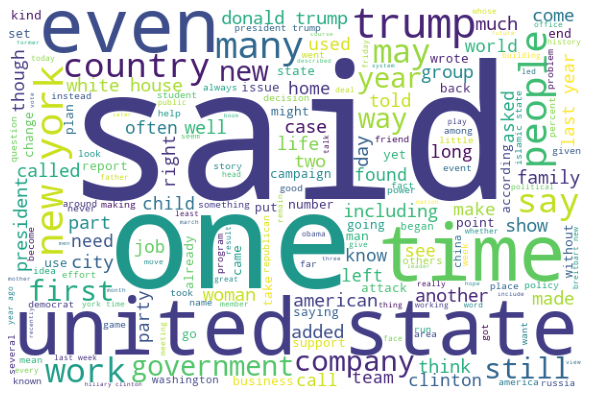

In [50]:
# worldcloud
text_words = extractWords(realnews)
plt.subplots(figsize = (8,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 600,
                    height = 400
                        ).generate(text_words)
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.tight_layout(pad=0)
plt.show()

#### <font color=green> ANALYSIS:- by looking at the graph it looks fake and real news has same words </font>

#### Lets dig into word count and understand more 

In [51]:
# find out number of words in title 
df['temp'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['temp','text']].head()


temp                                               text
0   820  House Dem Aide: We Didn’t Even See Comey’s Let...
1   727  Ever get the feeling your life circles the rou...
2  1266  Why the Truth Might Get You Fired October 29, ...
3   559  Videos 15 Civilians Killed In Single US Airstr...
4   154  Print \nAn Iranian woman has been sentenced to...

In [52]:
# find out the records which has only one words
q= "select count(temp) from df where  temp ==1 and text is not null"
joined = pysqldf(q)
joined

count(temp)
0            3

In [53]:
# find out the records which has more than 10 words
q= "select count(temp) from df where  temp <10 and text is not null"
joined = pysqldf(q)
joined

count(temp)
0          142

In [54]:
# records which has duplicate values
q= "select sum(cnt) - count(cnt) from (select count(label) as cnt from df where text is not null group by text having count(label)>1 ) "
joined = pysqldf(q)
joined

sum(cnt) - count(cnt)
0                    268

#### Lets compare word count of fake news and real news 

In [55]:
# find out number of words in title 
df['temp_word_title'] = df['title'].apply(lambda x: len(str(x).split(" ")))
df[['temp_word_title','title']].head()


temp_word_title                                              title
0               14  House Dem Aide: We Didn’t Even See Comey’s Let...
1                9  FLYNN: Hillary Clinton, Big Woman on Campus - ...
2                7                  Why the Truth Might Get You Fired
3               10  15 Civilians Killed In Single US Airstrike Hav...
4               14  Iranian woman jailed for fictional unpublished...

In [56]:
# max and min records on the words
q= "select max(temp_word_title),min(temp_word_title) from df where title is not null"
joined = pysqldf(q)
joined.head(1000)

max(temp_word_title)  min(temp_word_title)
0                    72                     1

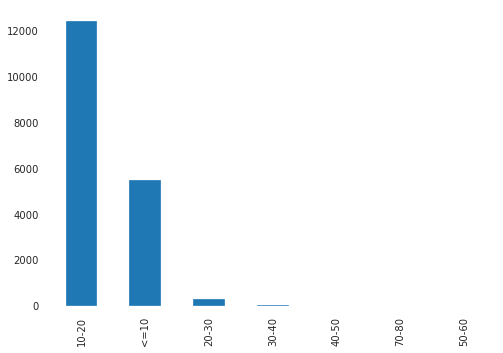

In [57]:
# words and lable comparision
q=  "select label, case when temp_word_title <= 10 then '<=10' when temp_word_title > 10 and temp_word_title <= 20 then '10-20' when temp_word_title > 20 and temp_word_title <= 30 then '20-30' when temp_word_title > 30 and temp_word_title <= 40 then '30-40' when temp_word_title > 40 and temp_word_title <= 50 then '40-50' when temp_word_title > 50 and temp_word_title <= 60 then '50-60' when temp_word_title > 60 and temp_word_title <= 70 then '60-70' when temp_word_title > 70 and temp_word_title <= 80 then '70-80' else 0 end as cnt from df where title is not null"
joined = pysqldf(q)
joined.head(10)
pd.value_counts(joined['cnt']).plot(kind="bar")

#### <font color=green> ANALYSIS:- By looking at the graph it looks <br> 1) if there are less than 10 words in the sentence then it is most probably fakenews </font>

#### Lets dig into text length and understand more 

In [58]:
# categorized data on sentence size 
q=  "select label, case when length(text) <= 1000 then '<=1000' when length(text) > 1000 and length(text) <=  2000 then  '1k-2k' when length(text) > 2000 and length(text) <=  3000 then  '2k-3k ' when length(text) > 3000 and length(text) <=  4000 then  '3k-4k ' when length(text) > 4000 and length(text) <=  5000 then  '4k-5k' when length(text) > 5000 and length(text) <=  6000 then  '5k-6k' when length(text) > 6000 and length(text) <=  7000 then  '6k-7k' when length(text) > 7000 and length(text) <=  8000 then  '7k-8k' when length(text) > 8000 and length(text) <=  9000 then  '8k-9k' when length(text) > 9000 and length(text) <=  10000 then  '9k-10k ' when length(text) > 10000 and length(text) <= 11000 then '10k-11k' when length(text) > 11000 and length(text) <= 12000 then '11k-12k' when length(text) > 12000 and length(text) <= 13000 then '12k-13k' when length(text) > 13000 and length(text) <= 14000 then '13k-14k' when length(text) > 14000 and length(text) <= 15000 then '14k-15k' when length(text) > 15000 and length(text) <= 16000 then '15k-16k'  else '>16k' end as cnt from df where text is not null"
joined = pysqldf(q)
joined.head()

label     cnt
0      1   4k-5k
1      0   4k-5k
2      1   7k-8k
3      1  3k-4k 
4      1  <=1000

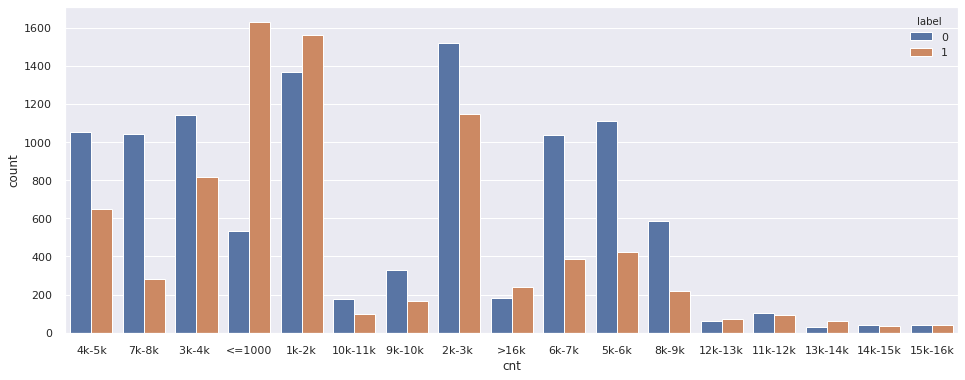

In [59]:
# words and lable comparision
plt.figure(figsize=(16, 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="cnt", hue="label", data=joined)
        

#### Distribution of text length for fake and real news 

In [60]:
x1 = df.loc[df['label'] == 1, 'text_len']
x0 = df.loc[df['label'] == 0, 'text_len']

trace1 = go.Histogram(
    x=x0, name='Real News',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Fake News',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of text length of text based on label')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

In [61]:
x1 = df.loc[df['label'] == 1, 'title_len']
x0 = df.loc[df['label'] == 0, 'title_len']

trace1 = go.Histogram(
    x=x0, name='Real News',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Fake News',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of text length of text based on label')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

#### <font color=green> ANALYSIS:- By looking at the graph it looks <br> 1) fake news text length is either small or very big  </font>

#### Analyze how author has contribute for fake/real news  

In [62]:
x1 = df.loc[df['label'] == 1, 'author']
x0 = df.loc[df['label'] == 0, 'author']

trace1 = go.Histogram(
    x=x0, name='Fake News',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Real News',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of text length of text based on label')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

#### <font color=green> ANALYSIS:- These people are giving the fake or real news. However, we will not consider author name for the model building becuase it might overfit the model </font>

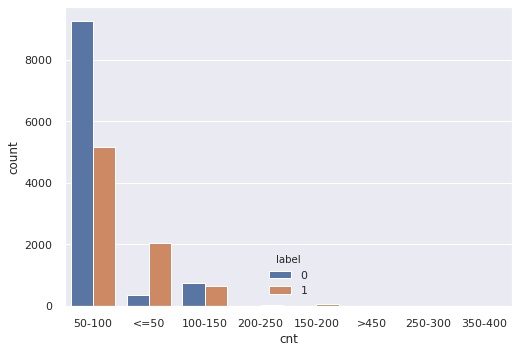

In [63]:
# categorized data on sentence size 
q=  "select label, case when length(title) <= 50 then '<=50' when length(title) > 50 and length(title) <= 100 then '50-100' when length(title) > 100 and length(title) <= 150 then '100-150' when length(title) > 150 and length(title) <= 200 then '150-200' when length(title) > 200 and length(title) <= 250 then '200-250' when length(title) > 250 and length(title) <= 300 then '250-300' when length(title) > 300 and length(title) <= 350 then '300-350' when length(title) > 350 and length(title) <= 400 then '350-400' when length(title) > 400 and length(title) <= 450 then '400-450'  when length(title) > 450  then '>450' else 0 end as cnt from df where title is not null"
joined = pysqldf(q)
# words and lable comparision

sns.set(style="darkgrid")
ax = sns.countplot(x="cnt", hue="label", data=joined)
        

In [64]:
import matplotlib.pyplot as plt 
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from xgboost import XGBRegressor
from nltk.corpus import stopwords
import nltk
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import logging
import config
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()  

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

class FeatureCreation():
    def __init__(self):
        pass

    def processText(self,df):
        by_article_list=[]
        for article in (df["text"]):
            words = word_tokenize(article)
            # words = [word.lower() for word in words if word.isalpha()] #lowercase
            words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
            words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form
            by_article_list.append(' '.join(words))
        return by_article_list

        

    def generate_features(self, data):
       
        logging.info("Generating Features")

        def get_word_count(column, analyzer):
            """
            Calculate the frequently used words from the entire bag of words using Count Vectorizer
            """
            count_vect = CountVectorizer(analyzer=analyzer)
            bag_of_words = count_vect.fit_transform(data[column])
            sum_of_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_of_words[0, i])
                          for word, i in count_vect.vocabulary_.items()]
            df = pd.DataFrame(words_freq, columns=['word', 'count'])
            return df

        def get_acronym_count(text):
            """
            Return the count of all the uppercase words
            Based on the assumption that if the word is in uppercase, it will be an Acronym.
            """

            text = str(text)
            count = 0
            for word in text.split():
                if word.isupper():
                    count += 1
            return count

       

        def get_numerical_value_count(text):
            """
            Return the count of occurences of numerical values in the text
            """

            text = str(text)
            return len([s for s in text.split() if s.isnumeric()])

        def get_pos_tagging(s):


            text = s['clean_text']
            VERB_count = 0
            NOUN_count = 0
            PRON_count = 0
            ADJ_count = 0
            ADVPN_count = 0
            ADP_count = 0
            CONJ_count = 0
            DET_count = 0
            NUM_count = 0
            PRT_count = 0
            PUNC_count = 0
            Action_count = 0
            

            pos_taggs = nltk.pos_tag(nltk.word_tokenize(text))

            for index, pos in enumerate(pos_taggs):
                if 'VB' in pos[1]:
                    VERB_count = VERB_count + 1

                elif 'NN' in pos[1]:
                    NOUN_count = NOUN_count + 1

                    if ((index - 1) > 0 and 'VB' in pos_taggs[index - 1][1]) or (
                            (index - 2) > 0 and 'VB' in pos_taggs[index - 2][1]) or (
                            (index + 1) < len(pos_taggs) and 'VB' in pos_taggs[index + 1][1]) or (
                            (index + 2) < len(pos_taggs) and 'VB' in pos_taggs[index + 2][1]):
                        Action_count = Action_count + 1                    

                elif pos[1] == 'WP':
                    PRON_count = PRON_count + 1
                elif pos[1] in ['JJ', 'JJR', 'JJS']:
                    ADJ_count = ADJ_count + 1
                elif pos[1] in ['ADV', 'RB', 'RBR', 'RBS']:
                    ADVPN_count = ADVPN_count + 1
                elif pos[1] == 'ADP':
                    ADP_count = ADP_count + 1
                elif pos[1] == 'CC ':
                    CONJ_count = CONJ_count + 1
                elif pos[1] == 'WDT':
                    DET_count = DET_count + 1
                elif pos[1] == 'CD':
                    NUM_count = NUM_count + 1
                elif pos[1] == 'RP':
                    PRT_count = PRT_count + 1
                elif pos[1] in ['.', ':', '']:
                    PUNC_count = PUNC_count + 1

            if len(pos_taggs) > 0:
                VERBRatio = VERB_count / len(pos_taggs)
                NOUNRatio = NOUN_count / len(pos_taggs)
                PRONRatio = PRON_count / len(pos_taggs)
                ADJRatio = ADJ_count / len(pos_taggs)
                ADVPNRatio = ADVPN_count / len(pos_taggs)
                ADPRatio = ADP_count / len(pos_taggs)
                CONJRatio = CONJ_count / len(pos_taggs)
                DETRatio = DET_count / len(pos_taggs)
                NUMRatio = NUM_count / len(pos_taggs)
                PRTRatio = PRT_count / len(pos_taggs)
                PUNCRatio = PUNC_count / len(pos_taggs)
            else:
                VERBRatio = 0
                NOUNRatio = 0
                PRONRatio = 0
                ADJRatio = 0
                ADVPNRatio = 0
                ADPRatio = 0
                CONJRatio = 0
                DETRatio = 0
                NUMRatio = 0
                PRTRatio = 0
                PUNCRatio = 0
            return VERBRatio, NOUNRatio, PRONRatio, ADJRatio, ADVPNRatio, ADPRatio, CONJRatio, DETRatio, NUMRatio, PRTRatio, PUNCRatio, Action_count

        # convert the column to string type
        data['clean_text'] = data['clean_text'].astype(str)

        # getting count of text lengthand word count 
        data['text_len'] = data['clean_text'].astype(str).apply(len)
        data['text_word_count'] = data['clean_text'].apply(lambda x: len(str(x).split()))
        
        #Unique word text count
        data['text_unique_word_count']=data["clean_text"].apply(lambda x: len(set(str(x).split())))


        # getting count of text lengthand word count 
        data['title_len'] = data['title'].astype(str).apply(len)
        data['title_word_count'] = data['title'].apply(lambda x: len(str(x).split()))

        #Unique word title count
        data['title_unique_word_count']=data["title"].apply(lambda x: len(set(str(x).split())))

 
        data[['VERBRatio', 'NOUNRatio', 'PRONRatio', 'ADJRatio',
              'ADVPNRatio', 'ADPRatio', 'CONJRatio', 'DETRatio', 'NUMRatio', 'PRTRatio', 'PUNCRatio',
              'ActionCount']] = data.apply(get_pos_tagging, axis=1, result_type="expand")

        logging.info("Creating Features: Acroynym")
        data['acronym_to_activity_ratio'] = data['clean_text'].apply(
            get_acronym_count)

        data['acronym count'] = data['clean_text'].apply(get_acronym_count)

        logging.info("Creating Features: Numeric Value Count")
        data['num value count'] = data['clean_text'].apply(
            get_numerical_value_count)

        
        logging.info("Creating Features: Last Activity Count")
        data['is_len_range_1_500'] = data.apply(
            lambda x: 1 if 0 < int(x['text_len']) <= 500 else 0, axis=1)

        logging.info("Creating Features: Last Activity Count")
        data['is_len_range_1_500'] = data.apply(
            lambda x: 1 if 0 < int(x['title_len']) <= 500 else 0, axis=1)

        logging.info("Creating Features: Last Activity Count")
        data['is_len_range_400_1100'] = data.apply(
            lambda x: 1 if 400 < int(x['text_len']) <= 1100 else 0, axis=1)

        logging.info("Creating Features: Last Activity Count")
        data['is_len_range_22_80'] = data.apply(
            lambda x: 1 if 22 < int(x['title_len']) <= 80 else 0, axis=1)

        logging.info("Features are created")
        return data



    def xgbclassifier(self, train_data, train_label, test_data, test_label):
        logging.info("Building XGB Classifier")
        model = xgb.XGBClassifier(objective="binary:logistic",
                                  random_state=7)
       

        model.fit(train_data, train_label, eval_set=[(test_data, test_label)],
                  eval_metric='auc',
                  early_stopping_rounds=100)

        y_pred = model.predict(test_data)
     
        # evaluate predictions
        accuracy = accuracy_score(test_label, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))

        # Feature Importance
        fig, ax = plt.subplots(figsize=(8, 12))
        xgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
        plt.show()
        return model

    

    
    def caculateFeatureImp(self):
        from numpy import loadtxt
        from numpy import sort
        from xgboost import XGBClassifier
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score
        from sklearn.feature_selection import SelectFromModel

        df_news = pd.read_csv(config.NEW_TRAINING_FILE).fillna("none").reset_index(drop=True)
        
        X, y = df_news.iloc[:,:-1],df_news.iloc[:,-1]
        
        y = df_news['label']
        X = df_news.drop(columns=['label'])
        X = X[['text_word_count', 'title_len', 'title_word_count', 'VERBRatio',
       'NOUNRatio', 'PRONRatio', 'ADJRatio', 'ADVPNRatio', 'ADPRatio',
       'CONJRatio', 'DETRatio', 'NUMRatio', 'PRTRatio', 'PUNCRatio',
       'ActionCount', 'acronym_to_activity_ratio', 'acronym count',
       'num value count', 'is_len_range_1_500','text_unique_word_count','title_unique_word_count']]


        data_dmatrix = xgb.DMatrix(data=X,label=y)

        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

       
        # fit model on all training data
        model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=10)
        model.fit(X_train, y_train)
        
        # make predictions for test data and evaluate
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        
        # Fit model using each importance as a threshold
        thresholds = sort(model.feature_importances_)
        print(thresholds)
        
        for thresh in thresholds:
            # select features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_X_train = selection.transform(X_train)
            # train model
            selection_model = XGBClassifier()
            selection_model.fit(select_X_train, y_train)
            # eval model
            select_X_test = selection.transform(X_test)
            predictions = selection_model.predict(select_X_test)
            accuracy = accuracy_score(y_test, predictions)
            print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    

    def execute_classifier(self):

        # self.caculateFeatureImp()

        logging.info("EDA")
        
        df_news = pd.read_csv('D:/Git/Assignment/input/data/train.csv').fillna("none").reset_index(drop=True)
        df_news.dropna(inplace=True)
        # df_train, df_test = model_selection.train_test_split(dfx, test_size=0.1, random_state=42, stratify=dfx.label.values)
        df_news['clean_text'] =self.processText(df_news)
        df_news.dropna(inplace=True)
        # print(df_news.head())
        df_news = self.generate_features(df_news.copy())
        print(df_news.columns)
        # df_news = df_news[['id', 'title', 'author', 'text', 'clean_text', 'text_len','text_word_count', 'title_len', 'title_word_count', 'VERBRatio',       'NOUNRatio', 'PRONRatio', 'ADJRatio', 'ADVPNRatio', 'ADPRatio',       'CONJRatio', 'DETRatio', 'NUMRatio', 'PRTRatio', 'PUNCRatio',       'ActionCount', 'acronym_to_activity_ratio', 'acronym count',       'num value count', 'is_len_range_1_500','label']]
        df_news.to_csv(config.NEW_TRAINING_FILE)


        df_news = pd.read_csv(config.NEW_TRAINING_FILE).fillna("none").reset_index(drop=True)
        print(df_news.columns)
        y = df_news['label']
        X = df_news.drop(columns=['label'])
        X = X[['text_word_count', 'title_len', 'title_word_count', 'VERBRatio',
       'NOUNRatio', 'PRONRatio', 'ADJRatio', 'ADVPNRatio', 'ADPRatio',
       'CONJRatio', 'DETRatio', 'NUMRatio', 'PRTRatio', 'PUNCRatio',
       'ActionCount', 'acronym_to_activity_ratio', 'acronym count',
       'num value count', 'is_len_range_1_500','text_unique_word_count','title_unique_word_count']]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # # ## Model - XGBoost
        self.xgb_model = self.xgbclassifier(X_train, y_train, X_test, y_test)

       

if __name__ == '__main__':
    rc = FeatureCreation()
    rc.execute_classifier()
    # rc.execute_regessors()

ModuleNotFoundError: No module named 'config'

#### <font color=green> ANALYSIS:- By looking at the graph it looks <br> 1) if the sentence size is less than 1kthen it is most probably fakenews </font>

In [ ]:

profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
''profile.to_notebook_iframe()

#### <font color=green> ANALYSIS:- Pandas Report <br> <br>PFB observation for Title field  <br>i.	Total 558 records which are null <br>ii.	 “titile” has 439 records the duplicate values <br>iii.	23 records which has only single word<br>iv.	33.55% records have less than 10 words  <br>v.	label “1” is assigned to the records which have null value<br>vi.	If we use BERT tokenizer then, we dont need to do the below text processing as BERT can handle it <br>    1.	We can check common words and remove those <br>    2.	We can check rare words and remove those <br>    3.	Spelling correction <br>    4.	Stemming <br>    5.	Lemmatization<br>vii.	IF the words is less than 10 words or more than 20 words then its high probability that it will be fake news <br>viii.	If the words between 10 to 20 then its high probability that it is real news  <br>ix.	Sentence size is less than 50 has highly fake news<br>x.	Average sentence size of the fake news is less than the real news <br>xi.	Outlier are exists for fake news <br><br>PFB observation for Text field<br>   1) todo </font>